In [12]:

import matplotlib.pyplot as plt
matplotlib.use('nbagg')
import math
import matplotlib.patches as patches
import matplotlib.animation as anm
import numpy as np

NameError: name 'matplotlib' is not defined

In [10]:
class IdealRobot:
    def __init__(self, pose, color="black"):
        self.pose = pose
        self.r = 0.2
        self.color = color
        
    def draw(self, ax, elems):
        x, y, theta = self.pose
        xn = x + self.r * math.cos(theta)
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([x, xn], [y, yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, color=self.color, fill=False)
        elems.append(ax.add_patch(c))

class World:
    def __init__(self, debug=False):
        self.objects = []
        self.debug = debug
    
    def append(self, obj):
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.set_aspect("equal")
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_xlabel("X", fontsize=20)
        ax.set_ylabel("Y", fontsize=20)
        
        elems = []
        
        if self.debug:
            for i in range(1000):
                self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=10, interval=1000, repeat=False)
            plt.show()
        
       
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        elems.append(ax.text(-4.4, 4,5, f"t={i}", fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)

/home/horino/.pyenv/versions/3.9.14/lib/python3.9/site-packages/matplotlib/animation.py:879: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


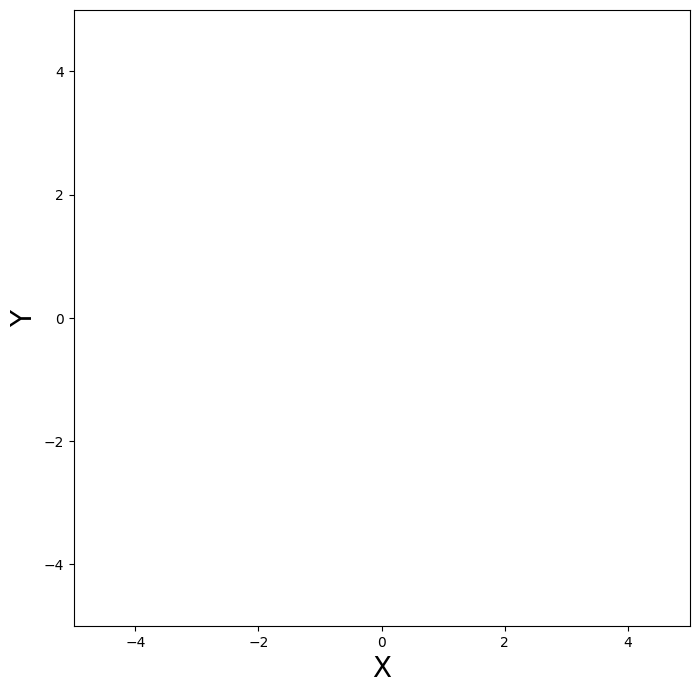

In [11]:
world = World()
robot1 = IdealRobot(np.array([2, 3, math.pi / 6]).T)
robot2 = IdealRobot(np.array([-2, -1, math.pi / 1]).T)
world.append(robot1)
world.append(robot2)
world.draw()